In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 1.8 MB/s eta 0:00:00m eta 0:00:010:00:01


# Austria

Data from https://opendem.info/opendemeu_download_highres.html

2024-11-11 00:25:17,141 - INFO - Combining 3 TIF files
2024-11-11 00:25:17,164 - INFO - Opened file: N260E450.tif
2024-11-11 00:25:17,165 - INFO -   Nodata value: -3.4028234663852886e+38
2024-11-11 00:25:17,165 - INFO -   Data type: float32
2024-11-11 00:25:17,172 - INFO - Opened file: N260E455.tif
2024-11-11 00:25:17,172 - INFO -   Nodata value: -3.4028234663852886e+38
2024-11-11 00:25:17,172 - INFO -   Data type: float32
2024-11-11 00:25:17,179 - INFO - Opened file: N260E460.tif
2024-11-11 00:25:17,179 - INFO -   Nodata value: -3.4028234663852886e+38
2024-11-11 00:25:17,180 - INFO -   Data type: float32
2024-11-11 00:25:17,585 - INFO - Files merged successfully
2024-11-11 00:25:17,585 - INFO - Combined heightmap shape: (2000, 6000)
2024-11-11 00:25:17,586 - INFO - Combined heightmap dtype: float32
2024-11-11 00:25:17,591 - INFO - Combined heightmap range: 417.7279357910156 to 3019.105224609375
2024-11-11 00:25:17,592 - INFO - Plotting heightmap


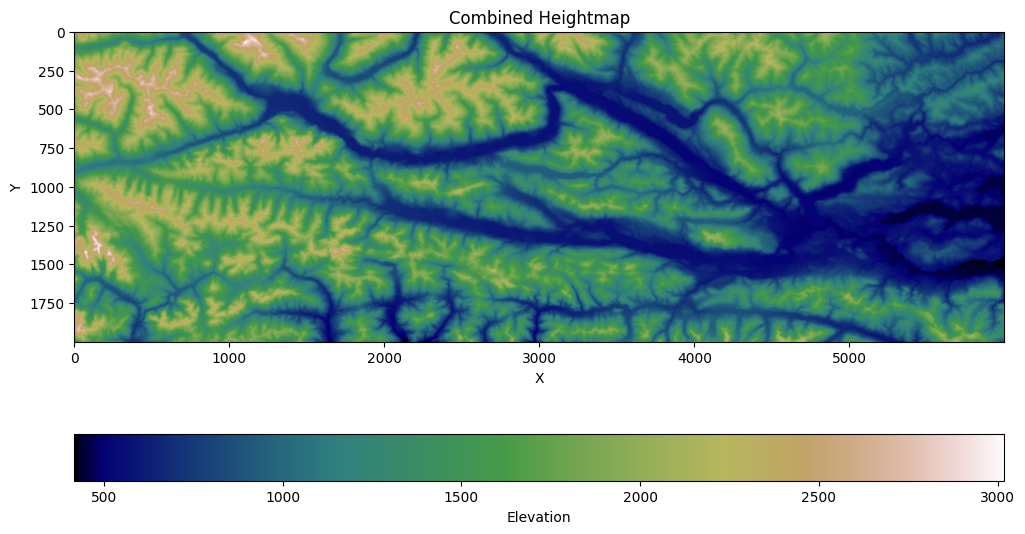

In [3]:
import rasterio
from rasterio.merge import merge
import matplotlib.pyplot as plt
import numpy as np
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def combine_tif_files(file_paths, nodata=None):
    logging.info(f"Combining {len(file_paths)} TIF files")
    # Open all the files
    src_files_to_mosaic = []
    for fp in file_paths:
        try:
            src = rasterio.open(fp)
            src_files_to_mosaic.append(src)
            logging.info(f"Opened file: {fp}")
            logging.info(f"  Nodata value: {src.nodata}")
            logging.info(f"  Data type: {src.dtypes[0]}")
        except Exception as e:
            logging.error(f"Error opening file {fp}: {e}")
    
    if not src_files_to_mosaic:
        raise ValueError("No files could be opened")
    
    # Merge the files
    try:
        mosaic, out_trans = merge(src_files_to_mosaic, nodata=nodata)
        logging.info("Files merged successfully")
    except Exception as e:
        logging.error(f"Error during merge: {e}")
        raise
    finally:
        # Close the files
        for src in src_files_to_mosaic:
            src.close()
    
    return mosaic[0]  # Return the first band

def plot_heightmap(heightmap_data):
    logging.info("Plotting heightmap")
    plt.figure(figsize=(12, 8))
    plt.imshow(heightmap_data, cmap='gist_earth')
    plt.colorbar(label='Elevation', orientation='horizontal')
    plt.title('Combined Heightmap')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

def downsample_heightmap(heightmap, target_height, target_width):
    logging.info(f"Downsampling heightmap from {heightmap.shape} to {target_height}x{target_width}")
    current_height, current_width = heightmap.shape
    
    # Calculate the downsampling factors
    height_factor = current_height // target_height
    width_factor = current_width // target_width
    
    # Ensure the factors are at least 1
    height_factor = max(1, height_factor)
    width_factor = max(1, width_factor)
    
    # Calculate the new dimensions
    new_height = current_height // height_factor
    new_width = current_width // width_factor
    
    # Reshape and mean
    reshaped = heightmap[:new_height*height_factor, :new_width*width_factor]
    reshaped = reshaped.reshape(new_height, height_factor, new_width, width_factor)
    downsampled = reshaped.mean(axis=(1, 3))
    
    logging.info(f"Downsampled heightmap shape: {downsampled.shape}")
    return downsampled

def main():
    # List of your .tif files
    file_paths = ['N260E450.tif', 'N260E455.tif', 'N260E460.tif']
    
    try:
        # Combine the .tif files
        heightmap = combine_tif_files(file_paths, nodata=-9999)  # Use an appropriate nodata value
        
        logging.info(f"Combined heightmap shape: {heightmap.shape}")
        logging.info(f"Combined heightmap dtype: {heightmap.dtype}")
        logging.info(f"Combined heightmap range: {heightmap.min()} to {heightmap.max()}")
        
        # Normalize the heightmap to 0-1 range
        #heightmap = (heightmap - heightmap.min()) / (heightmap.max() - heightmap.min())
        #logging.info("Heightmap normalized")
        
        # Downsample heightmap
        #heightmap = downsample_heightmap(heightmap, 200, 600)
        
        # Plot the heightmap
        plot_heightmap(heightmap)

        np.save(f"austria_{2000}_{6000}_heightmap_wo_norm.npy", heightmap)
        
    except Exception as e:
        logging.error(f"An error occurred: {e}")

if __name__ == "__main__":
    main()